In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping


2025-07-02 17:24:30.418665: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751477070.616881     420 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751477070.676035     420 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
train_path = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_path = "/kaggle/input/intel-image-classification/seg_test/seg_test"
pred_path = "/kaggle/input/intel-image-classification/seg_pred/seg_pred"

In [5]:
Classes = {name: idx for idx, name in enumerate(os.listdir(train_path))}

In [6]:
print(Classes)

{'mountain': 0, 'street': 1, 'buildings': 2, 'sea': 3, 'forest': 4, 'glacier': 5}


## print the number of each class in training data

In [7]:
for class_name in os.listdir(train_path):
    class_path = os.path.join(train_path, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class '{class_name}': {num_images} images")

Class 'mountain': 2512 images
Class 'street': 2382 images
Class 'buildings': 2191 images
Class 'sea': 2274 images
Class 'forest': 2271 images
Class 'glacier': 2404 images


## print the number of each class in test data

In [8]:
for class_name in os.listdir(test_path):
    class_path = os.path.join(test_path, class_name)
    num_images = len(os.listdir(class_path))
    print(f"Class '{class_name}': {num_images} images")

Class 'mountain': 525 images
Class 'street': 501 images
Class 'buildings': 437 images
Class 'sea': 510 images
Class 'forest': 474 images
Class 'glacier': 553 images


In [9]:
size = []
for folder in os.listdir(train_path):
    class_path = os.path.join(train_path, folder)
    if os.path.isdir(class_path):
        for img in os.listdir(class_path):
            img_path = os.path.join(class_path, img)
            try:
                image = plt.imread(img_path)
                size.append(image.shape)
            except Exception as e:
                continue

print(pd.Series(size).value_counts())

(150, 150, 3)    13986
(113, 150, 3)        7
(135, 150, 3)        3
(111, 150, 3)        3
(144, 150, 3)        2
(143, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(108, 150, 3)        2
(136, 150, 3)        2
(134, 150, 3)        2
(146, 150, 3)        2
(100, 150, 3)        1
(141, 150, 3)        1
(103, 150, 3)        1
(145, 150, 3)        1
(147, 150, 3)        1
(131, 150, 3)        1
(81, 150, 3)         1
(140, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
(149, 150, 3)        1
(110, 150, 3)        1
(105, 150, 3)        1
(97, 150, 3)         1
(120, 150, 3)        1
(76, 150, 3)         1
(119, 150, 3)        1
(102, 150, 3)        1
Name: count, dtype: int64


In [10]:
size = []
for folder in os.listdir(test_path):
    class_path = os.path.join(test_path, folder)
    if os.path.isdir(class_path):
        for img in os.listdir(class_path):
            img_path = os.path.join(class_path, img)
            try:
                image = plt.imread(img_path)
                size.append(image.shape)
            except Exception as e:
                continue

print(pd.Series(size).value_counts())

(150, 150, 3)    2993
(81, 150, 3)        1
(131, 150, 3)       1
(141, 150, 3)       1
(149, 150, 3)       1
(110, 150, 3)       1
(76, 150, 3)        1
(72, 150, 3)        1
Name: count, dtype: int64


In [11]:
IMG_SIZE = (150, 150)
X_trainL = []
y_trainL = []

for class_name, class_index in Classes.items():
    class_path = os.path.join(train_path, class_name)
    for img_name in  tqdm(os.listdir(class_path), desc=f"Loading {class_name}"):
        img_path = os.path.join(class_path, img_name)
        try:
            img = cv2.imread(img_path)
            resized_img= cv2.resize(img, IMG_SIZE)
            X_trainL.append(resized_img)
            y_trainL.append(class_index)
        except Exception as e:
            continue  # continue if error

Loading glacier: 100%|██████████| 2404/2404 [00:02<00:00, 808.51it/s]


In [12]:
X_train = np.array(X_trainL)
X_train.shape

(14034, 150, 150, 3)

In [13]:
y_train = np.array(y_trainL)
y_train.shape

(14034,)

In [14]:
def getname(label):
    for class_name, class_index in Classes.items():
        if label == class_index:
            return class_name

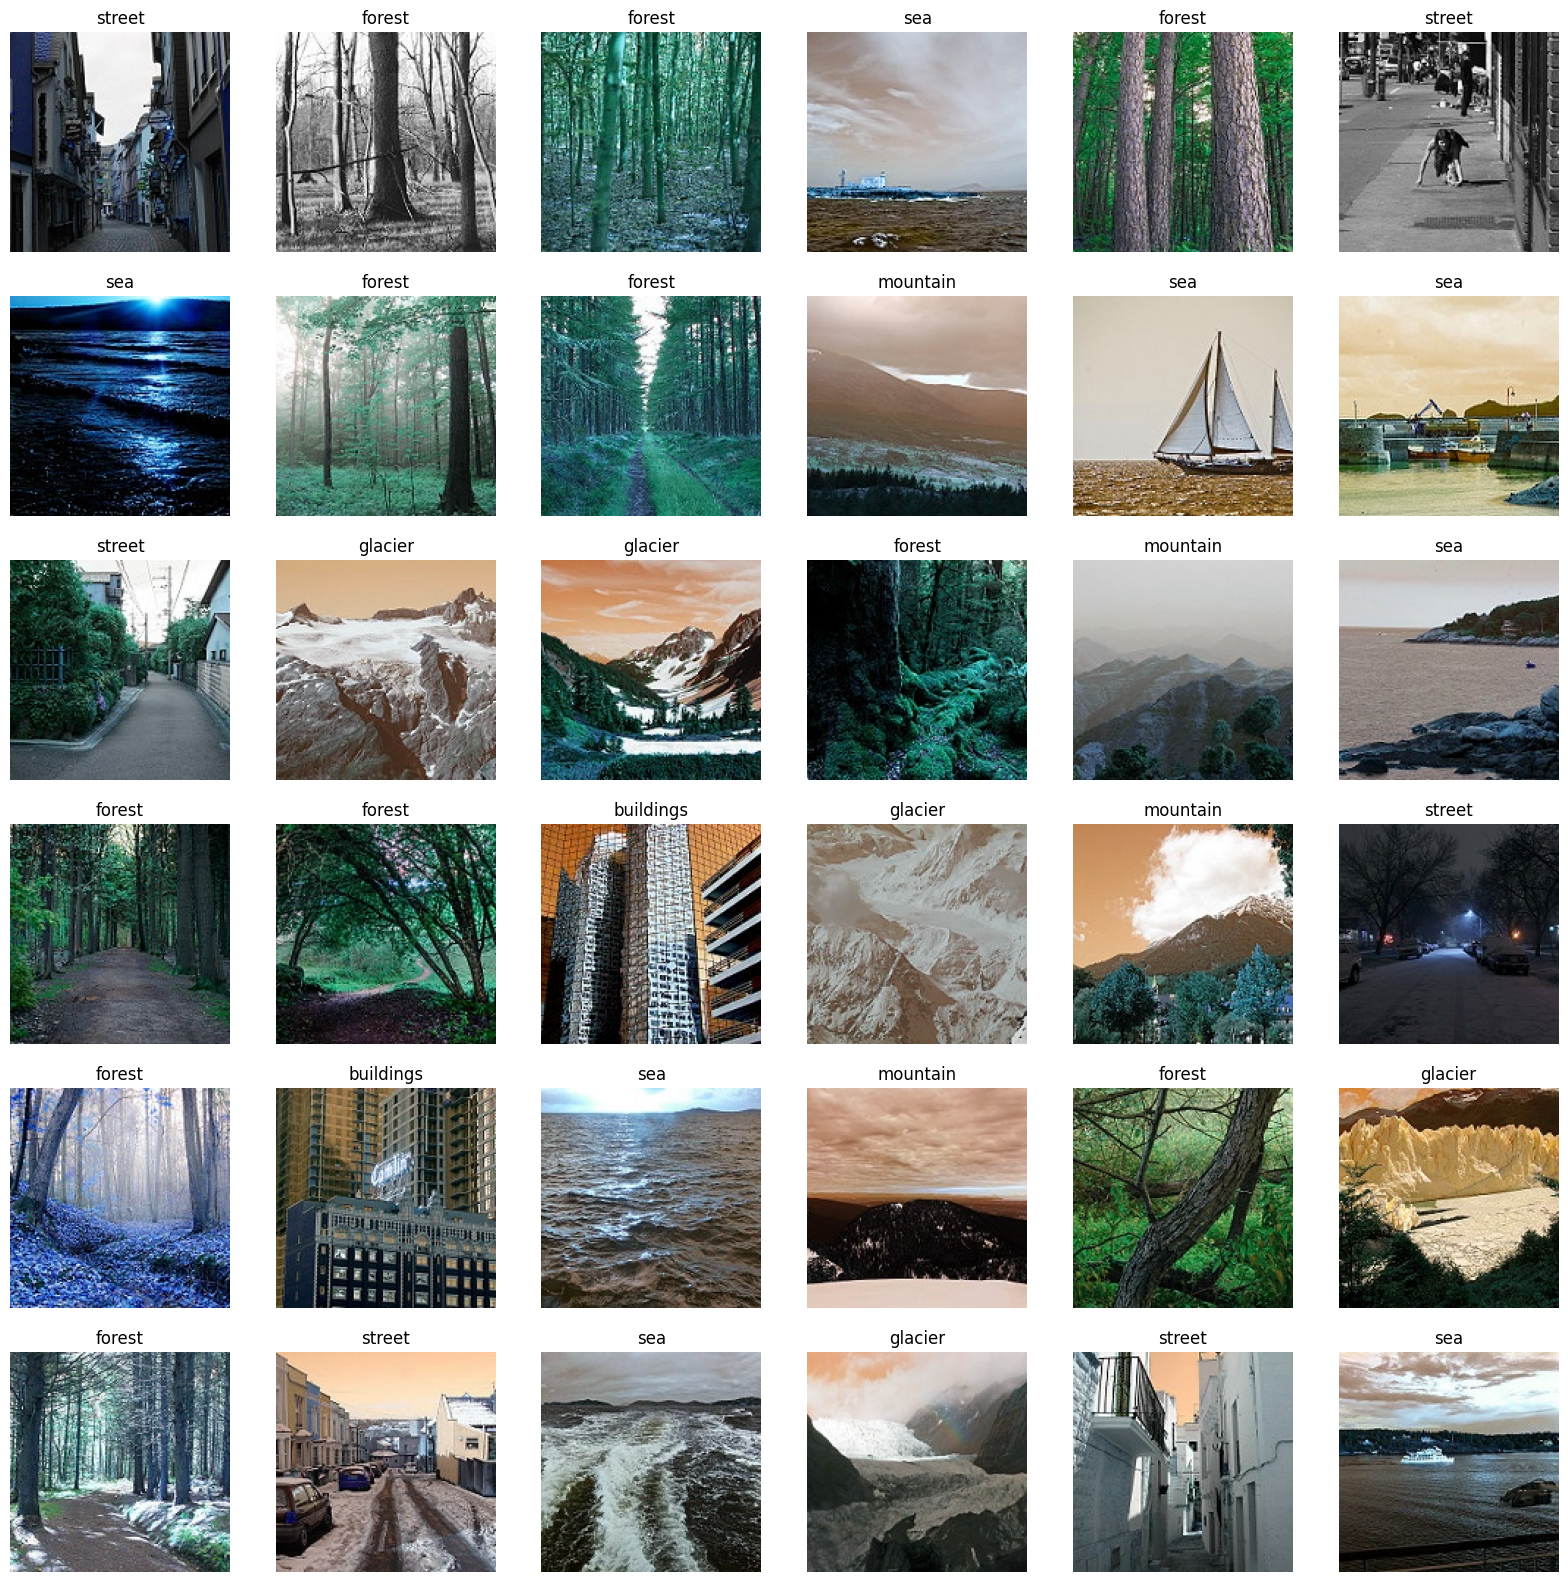

In [15]:
plt.figure(figsize=(20, 20))

for n, i in enumerate(list(np.random.randint(0, len(X_train), 36))):
    plt.subplot(6, 6, n + 1)             # Create a 6x6 grid of subplots
    plt.imshow(X_train[i])              # Show the image at index i
    plt.axis('off')
    plt.title(getname(y_train[i]))      # Title from label using getcode()

In [16]:
IMG_SIZE = (150, 150)
X_testL = []
y_testL = []

for class_name, class_index in Classes.items():
    class_path = os.path.join(test_path, class_name)
    for img_name in  tqdm(os.listdir(class_path), desc=f"Loading {class_name}"):
        img_path = os.path.join(class_path, img_name)
        try:
            img = cv2.imread(img_path)
            resized_img= cv2.resize(img, IMG_SIZE)
            X_testL.append(resized_img)
            y_testL.append(class_index)
        except Exception as e:
            continue  # continue if error

Loading glacier: 100%|██████████| 553/553 [00:00<00:00, 663.42it/s]


In [17]:
X_test = np.array(X_testL)
X_test.shape

(3000, 150, 150, 3)

In [18]:
y_test = np.array(y_testL)
y_test.shape

(3000,)

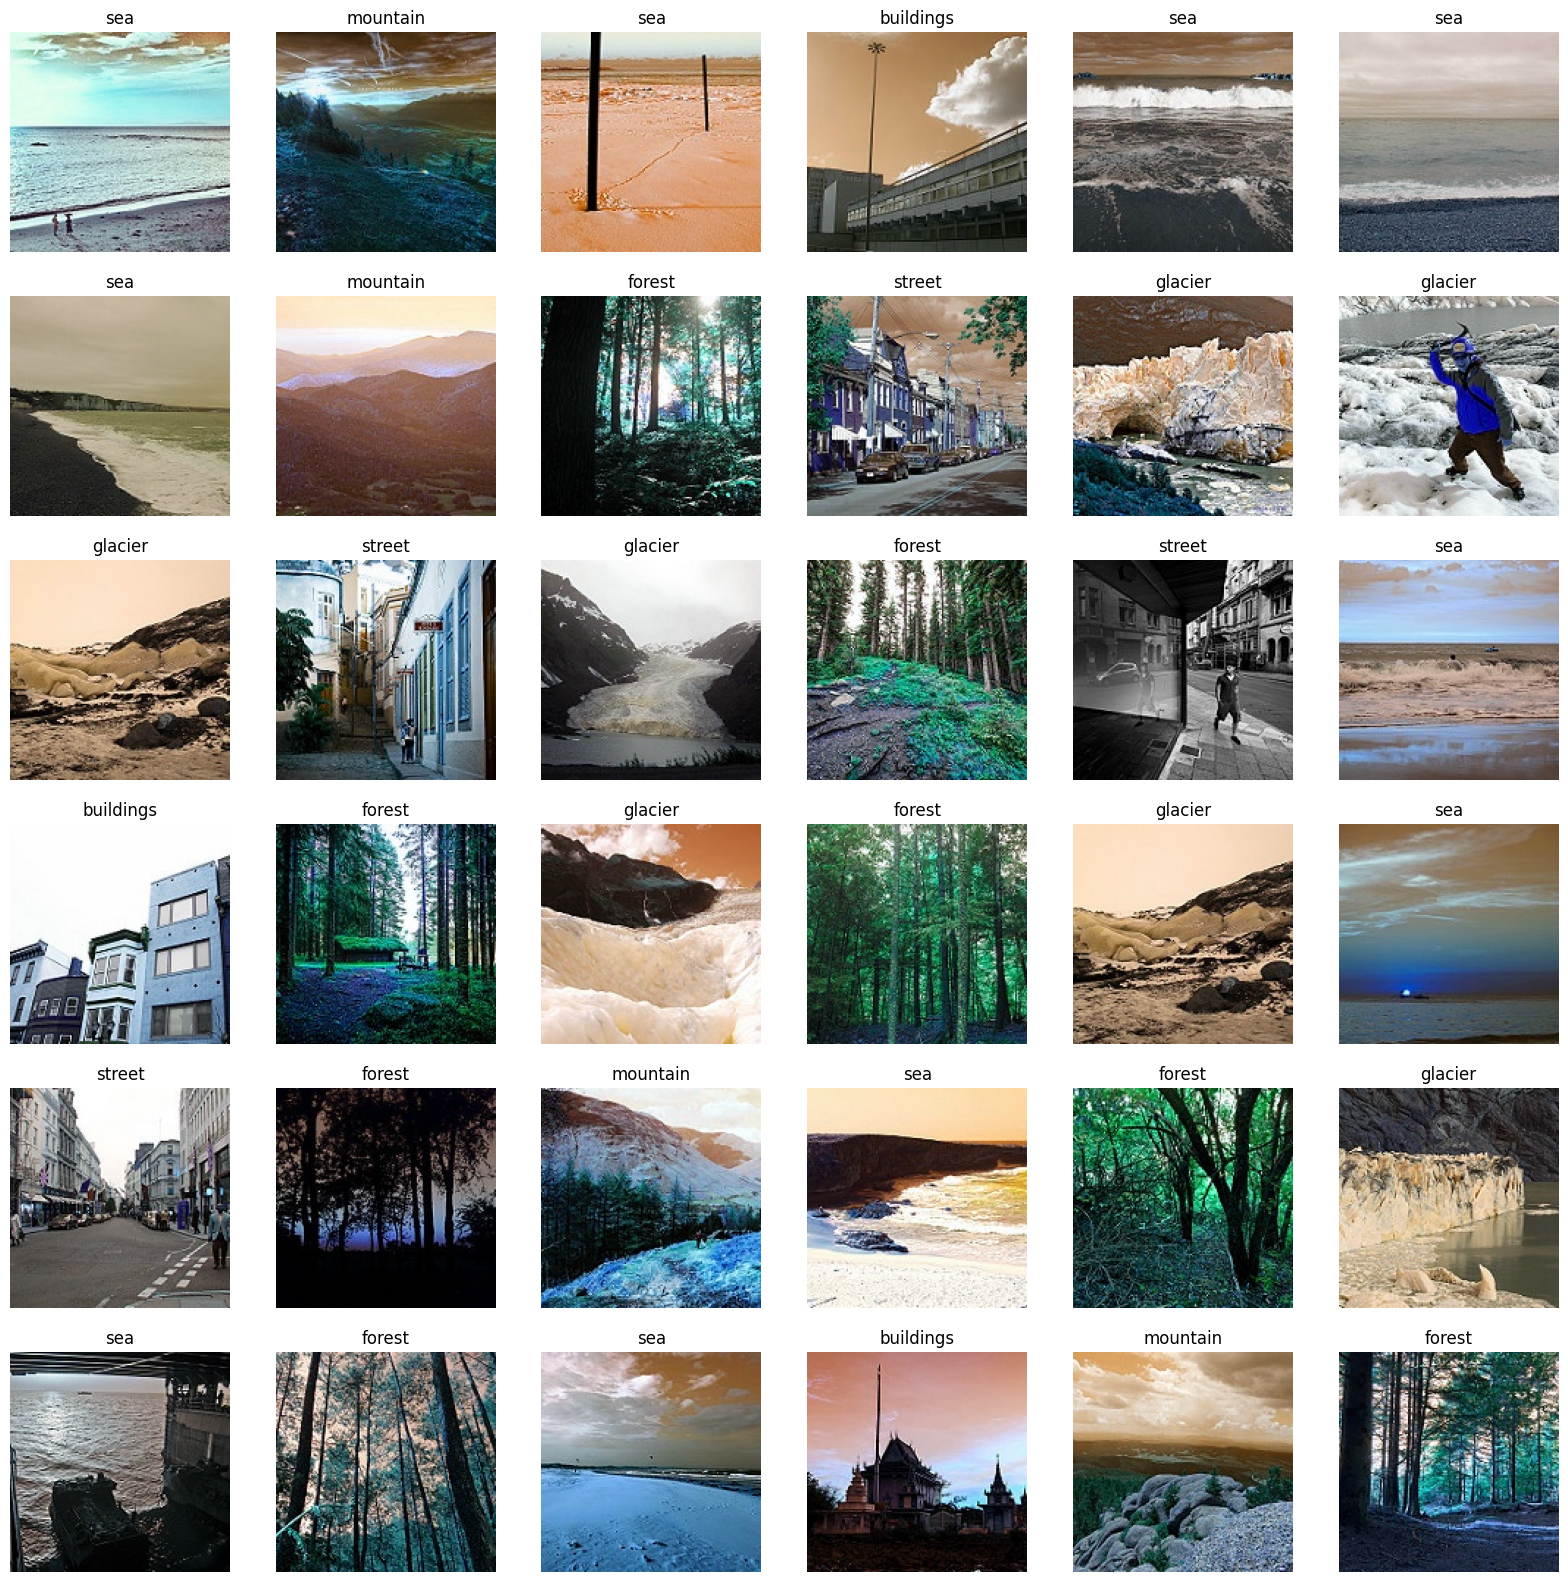

In [19]:
plt.figure(figsize=(20, 20))  # Set figure size

# Randomly pick 36 indices from X_train
for n, i in enumerate(list(np.random.randint(0, len(X_test), 36))):
    plt.subplot(6, 6, n + 1)             # Create a 6x6 grid of subplots
    plt.imshow(X_test[i])              # Show the image at index i
    plt.axis('off')
    plt.title(getname(y_test[i]))      # Title from label using getcode()

## Noramlize

In [31]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [28]:
# X_train = X_train * 255.0
# X_test = X_test * 255.0

In [20]:
X_train[0][0][0]

array([216, 203, 189], dtype=uint8)

## saving X_train, y_train

In [22]:
import pickle
# Save X_train
with open('/kaggle/working/X_train.pickle', 'wb') as f:
    pickle.dump(X_train, f)
    
# Save y_train
with open('/kaggle/working/y_train.pickle', 'wb') as f:
    pickle.dump(y_train, f)

## load X_train, y_train

In [25]:
# Load X_train
with open('/kaggle/working/X_train.pickle', 'rb') as f:
    X_train = pickle.load(f)

# Load y_train
with open('/kaggle/working/y_train.pickle', 'rb') as f:
    y_train = pickle.load(f)

## saving X_test, y_test

In [24]:
import pickle

# Save X_train
with open("/kaggle/working/X_test.pickle", "wb") as f:
    pickle.dump(X_test, f)

# Save y_train
with open("/kaggle/working/y_test.pickle", "wb") as f:
    pickle.dump(y_test, f)

## load X_test, y_test

In [26]:
# Load X_train
with open('/kaggle/working/X_test.pickle', 'rb') as f:
    X_train = pickle.load(f)

# Load y_train
with open('/kaggle/working/y_test.pickle', 'rb') as f:
    y_train = pickle.load(f)

In [41]:
model1 = Sequential([
    Input(shape=(150, 150, 3)),
    
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((4, 4)),

    # Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    # MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(6, activation='softmax')
])


In [42]:
model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [43]:
model1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │       2,654,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,682,374 (10.23 MB)

 Trainable params: 2,682,374 (10.23 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
model1.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.1, shuffle=True)

Epoch 1/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.3644 - loss: 1.6076 - val_accuracy: 0.5267 - val_loss: 1.1904
Epoch 2/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5709 - loss: 1.1160 - val_accuracy: 0.6100 - val_loss: 1.0233
Epoch 3/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6443 - loss: 0.9286 - val_accuracy: 0.6200 - val_loss: 1.0275
Epoch 4/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7032 - loss: 0.7991 - val_accuracy: 0.6700 - val_loss: 0.8541
Epoch 5/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.7521 - loss: 0.7199 - val_accuracy: 0.7000 - val_loss: 0.8660
Epoch 6/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8190 - loss: 0.5538 - val_accuracy: 0.7033 - val_loss: 0.8298
Epoch 7/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8287 - loss: 0.5236 - val_accuracy: 0.7300 - val_loss: 0.8247
Epoch 8/10
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8582 - loss: 0.4214 - val_accuracy: 0.7267 - v

In [71]:
loss, accuracy = model1.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9634 - loss: 0.1822
Test Loss: 0.1857
Test Accuracy: 0.9610


## Saving the model

In [27]:
model1.save('/kaggle/working/my_model1.h5')

In [77]:
model2 = Sequential([
    Input(shape=(150, 150, 3)),

    Conv2D(200, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    Conv2D(150, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((4, 4)),

    Conv2D(120, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # 6 classes
])

In [78]:
from tensorflow.keras.optimizers import Adam
model2.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [79]:
model2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)                   │ (None, 150, 150, 200)       │           5,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 150, 150, 150)       │         270,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 37, 37, 150)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 37, 37, 120)         │         162,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 18, 18, 120)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 38880)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │       4,976,768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,423,284 (20.69 MB)

 Trainable params: 5,423,284 (20.69 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
model2.fit(X_train, y_train, batch_size=32, epochs=15 , validation_split=0.1, shuffle=True)

Epoch 1/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 63s 482ms/step - accuracy: 0.3034 - loss: 1.8811 - val_accuracy: 0.5733 - val_loss: 1.2592
Epoch 2/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 22s 261ms/step - accuracy: 0.5271 - loss: 1.3565 - val_accuracy: 0.5667 - val_loss: 1.1823
Epoch 3/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 271ms/step - accuracy: 0.6000 - loss: 1.1867 - val_accuracy: 0.6233 - val_loss: 1.0479
Epoch 4/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 271ms/step - accuracy: 0.6321 - loss: 1.0590 - val_accuracy: 0.5900 - val_loss: 1.0671
Epoch 5/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 266ms/step - accuracy: 0.6799 - loss: 1.0007 - val_accuracy: 0.6233 - val_loss: 1.0889
Epoch 6/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 266ms/step - accuracy: 0.6985 - loss: 0.9019 - val_accuracy: 0.6800 - val_loss: 1.0109
Epoch 7/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 270ms/step - accuracy: 0.7609 - loss: 0.8201 - val_accuracy: 0.7133 - val_loss: 0.8897
Epoch 8/15
85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 270ms/step - accuracy: 0.7929 - loss: 0.6915 - val_accu

In [81]:
loss, accuracy = model2.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.9384 - loss: 0.3165
Test Loss: 0.3197
Test Accuracy: 0.9357
